In [1]:
import pandas as pd
import numpy as np
from ast import literal_eval
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score

%matplotlib inline

In [51]:
spend_train = pd.read_csv('data/spend_train.csv')
acq_train = pd.read_csv('data/acquisition_train.csv', parse_dates=True)
acq_test= pd.read_csv('data/acquisition_test.csv', parse_dates=True)

In [3]:
spend_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980818 entries, 0 to 980817
Data columns (total 7 columns):
ids                  980818 non-null object
credit_line          980818 non-null int64
month                980818 non-null int64
spends               980818 non-null float64
revolving_balance    980818 non-null float64
card_request         980818 non-null int64
minutes_cs           980818 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 52.4+ MB


In [5]:
spend_train.describe()

,credit_line,month,spends,revolving_balance,card_request,minutes_cs
count,980818.000000,980818.000000,980818.000000,980818.000000,980818.000000,980818.000000
mean,6450.701643,12.103346,2878.074202,481.071351,0.092795,2.791051
std,4564.596250,8.515882,3529.032134,1431.827450,0.290145,6.644611
min,506.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2948.000000,5.000000,334.760000,0.000000,0.000000,0.000000
50%,5314.000000,11.000000,1568.165000,1.530000,0.000000,0.000000
75%,8763.000000,18.000000,4129.000000,141.660000,0.000000,1.720000
max,20484.000000,35.000000,20462.230000,20369.440000,1.000000,75.580000


In [52]:
spend_ids = set(spend_train['ids'].values.tolist())
acq_ids = set(acq_train['ids'].values.tolist())
acqtest_ids = set(acq_test['ids'].values.tolist())

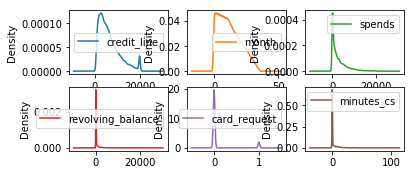

In [61]:
spend_train.plot(kind='density', subplots=True, layout=(3,3), sharex=False)
plt.show()

## Analysis

In [65]:
agg_spend = spend_train.groupby('ids').agg(
    {'credit_line':['min','mean','max'],
     'month':['max'],
     'spends':['min','max','mean','median', 'sum'],
     'revolving_balance':['min','max','mean','median', 'sum'],
     'card_request':['sum'],
     'minutes_cs':['sum']
    }
    )

In [81]:
agg_spend[agg_spend['credit_line']['min'] != agg_spend['credit_line']['max']]

credit_line month  spends            \
                                             min   max     min       max   
ids                                                                        
0003da40-123b-031a-63b3-f7c9f18516ab       20314    17    0.00  20268.75   
0004a450-07bd-c652-8473-4e9dedcff8b8       19973    18  348.00  19327.57   
0005967a-2048-6197-a054-30954efe93b1       11728     8   15.38  10703.30   
0009b1d5-f5c3-428e-63dd-39b5f04ad7df        3117    19    0.00   3116.41   
0010b103-a9e4-e08f-ce04-0c65e71a6df9       20000    12  120.40  19667.60   

                                                                        \
                                             mean    median        sum   
ids                                                                      
0003da40-123b-031a-63b3-f7c9f18516ab  4631.845000  1032.460   83373.21   
0004a450-07bd-c652-8473-4e9dedcff8b8  9819.764737  9314.420  186575.53   
0005967a-2048-6197-a054-30954efe93b1  5158.547778  5141.570   46426.93   
0009b1d5-f5c3-428e-63dd-39b5f04ad7df  1778.792500  2149.385   35575.85   
0010b103-a9e4-e08f-ce04-0c65e71a6df9  7772.272308  5058.400  101039.54   

                                     revolving_balance                         \
                                                   min       max         mean   
ids                                                                             
0003da40-123b-031a-63b3-f7c9f18516ab              0.00  19109.42  2255.217778   
0004a450-07bd-c652-8473-4e9dedcff8b8              0.00   6909.14  1058.767368   
0005967a-2048-6197-a054-30954efe93b1              0.22   2706.71   428.543333   
0009b1d5-f5c3-428e-63dd-39b5f04ad7df              0.00   2726.68   539.288500   
0010b103-a9e4-e08f-ce04-0c65e71a6df9              0.00   9310.31  1315.901538   

                                                       card_request minutes_cs  
                                      median       sum          sum        sum  
ids                                                                             
0003da40-123b-031a-63b3-f7c9f18516ab   0.235  40593.92            3      21.50  
0004a450-07bd-c652-8473-4e9dedcff8b8   0.140  20116.58            1      52.71  
0005967a-2048-6197-a054-30954efe93b1  13.200   3856.89            1      54.37  
0009b1d5-f5c3-428e-63dd-39b5f04ad7df  11.340  10785.77            1      44.08  
0010b103-a9e4-e08f-ce04-0c65e71a6df9   3.340  17106.72            1      12.81

In [70]:
agg_spend = spend_train.groupby('ids').agg(
    {'credit_line':['min'],
     'month':['max'],
     'spends':['min','max','mean','median', 'sum'],
     'revolving_balance':['min','max','mean','median', 'sum'],
     'card_request':['sum'],
     'minutes_cs':['sum']
    }
    )
agg_spend.columns = ['_'.join(col).strip() for col in agg_spend.columns.values]

In [106]:
agg_spend.values

array([[  2.03140000e+04,   1.70000000e+01,   0.00000000e+00, ...,
          4.05939200e+04,   3.00000000e+00,   2.15000000e+01],
       [  1.99730000e+04,   1.80000000e+01,   3.48000000e+02, ...,
          2.01165800e+04,   1.00000000e+00,   5.27100000e+01],
       [  1.17280000e+04,   8.00000000e+00,   1.53800000e+01, ...,
          3.85689000e+03,   1.00000000e+00,   5.43700000e+01],
       ..., 
       [  4.01200000e+03,   1.70000000e+01,   0.00000000e+00, ...,
          3.94907000e+03,   3.00000000e+00,   3.28700000e+01],
       [  1.22270000e+04,   1.80000000e+01,   0.00000000e+00, ...,
          3.11369200e+04,   1.00000000e+00,   7.40600000e+01],
       [  5.25000000e+03,   2.40000000e+01,   0.00000000e+00, ...,
          6.04203000e+03,   3.00000000e+00,   4.78200000e+01]])

In [82]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Create scaler: scaler
scaler = StandardScaler()

# Create KMeans instance: kmeans
kmeans = KMeans(n_clusters=4)

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,kmeans)

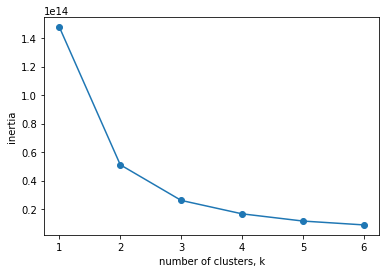

In [99]:


ks = range(1, 7)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(agg_spend)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()


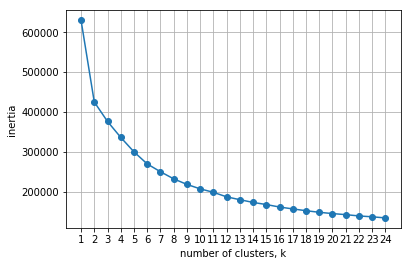

45000
(45000, 14)


In [114]:
# Perform the necessary imports
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Create scaler: scaler
scaler = StandardScaler()

agg_spend = scaler.fit_transform(agg_spend)


ks = range(1, 25)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(agg_spend)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.grid()
plt.show()

print(len(labels))
print(agg_spend.shape)


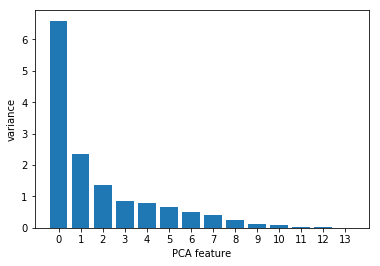

In [115]:
# Perform the necessary imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

# Create scaler: scaler
scaler = StandardScaler()

# Create a PCA instance: pca
pca = PCA()

# Create pipeline: pipeline
pipeline = make_pipeline(scaler,pca)

# Fit the pipeline to 'samples'
pipeline.fit(agg_spend)

# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_)
plt.xlabel('PCA feature')
plt.ylabel('variance')
plt.xticks(features)
plt.show()

## Plots

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a2cf10ef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a2d6670f0>]], dtype=object)

<Figure size 720x1080 with 0 Axes>

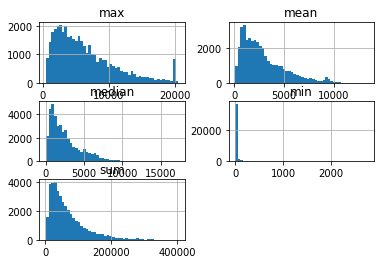

In [80]:
plt.figure(figsize=(10,15))
agg_spend[agg_spend['month']['max']>10]['spends'].hist(bins=50)

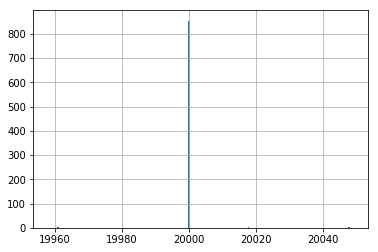

In [24]:
spend_train[
(spend_train['credit_line']>19950) &
(spend_train['credit_line']<20050)
].drop_duplicates(['ids','credit_line'])['credit_line'].hist(bins=200)

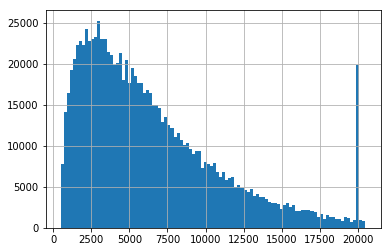

In [14]:
spend_train['credit_line'].hist(bins=100)

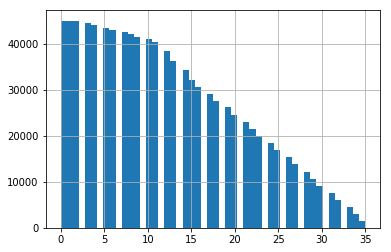

In [43]:
spend_train['month'].hist(bins=50)

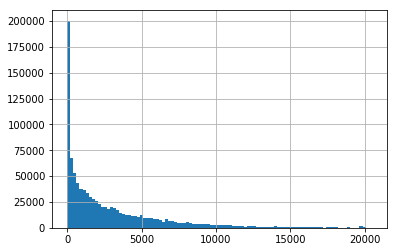

In [12]:
spend_train['spends'].hist(bins=100)

In [13]:
spend_train['ids'].drop_duplicates().shape

(45000,)